<a href="https://colab.research.google.com/github/shamalle/emotion_recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion recognition with neural network

## Data set used: Fer2013

* approx. 30'000 facial RGB images 
* 48x48 pixels
* 7 classes: angry (0), disgust (1), fear (2), happy (3), sad (4), suprise (5), neutral (6)
* ~ 5'000 samples/class with exception of disgust (1): 600 samples

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, RandomHorizontalFlip, RandomRotation, Grayscale
from torchvision.utils import make_grid
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import random
import cv2 # pip install opencv-python
import pandas as pd
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/data_directory.zip" /content/data.zip
!unzip /content/data.zip -d /content/data/

# Data analysis: Distribution of classes and visualisation of samples

First, helper functions are defined

In [44]:
def count_samples(path, set_):
  ''' Counts amount of samples of each class in train set and in test set and total amount, too'''
  expr_amount_dict = {} # counts how many samples per class
  total_amount_of_dataset = 0 # counts how many samples per dataset in total
  # go through each expression
  for expr in os.listdir(path):
    dir_ = path + '/' + expr
    # save amount of samples to each expression
    expr_amount_dict[expr] = len(os.listdir(dir_))
    # increment amount of total samples
    total_amount_of_dataset += len(os.listdir(dir_))
    expr_amount_dict['total'] = total_amount_of_dataset
  
  # nice visualisation with pd
  df = pd.DataFrame(expr_amount_dict, 
                    index=[set_], 
                    columns = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'total'])
  return df


def plot_images(img_dir, title):
  '''Plots 5 random images from given directory'''
  all_imgs = os.listdir(img_dir)
  rndm_samples = random.sample(range(0, len(all_imgs)), 5)
  img_files = [os.path.join(img_dir, file) for file in all_imgs]
  rndm_imgs = itemgetter(*rndm_samples)(img_files)
  
  plt.figure(figsize=(12, 12))
  for idx, img_path in enumerate(rndm_imgs):
    plt.subplot(5, 5, idx+1)
    img = plt.imread(img_path)
    plt.title(title)
    plt.axis('off')         
    plt.imshow(img, cmap='Greys_r') 

In [45]:
# Google colab directories:
train_dir = '/content/data/data_directory/train'
test_dir = '/content/data/data_directory/test'

In [46]:
train_count = count_samples(train_dir, 'train')
test_count = count_samples(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise  total
train   3995      436  4097   7215     4965  4830      3171  28709
      angry  disgust  fear  happy  neutral   sad  surprise  total
test    958      111  1024   1774     1233  1247       831   7178


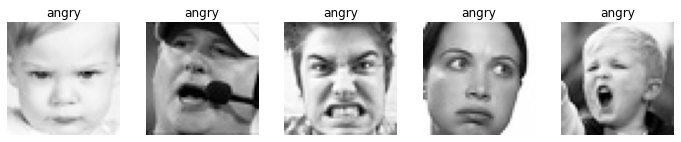

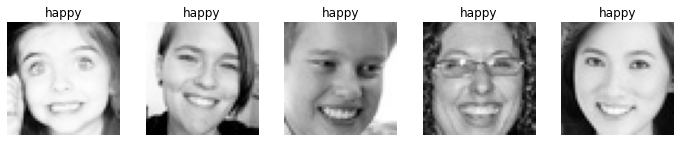

In [47]:
emotion = 'angry'
emotion_2 = 'happy'

plot_images(train_dir+'/'+emotion, emotion)
plot_images(train_dir+'/'+emotion_2, emotion_2)

# Data preparation

Helper functions to load/split data.

Transformations used: Grayscale, random rotation and random horizontal flip. This helps to not have a fixating model on unnecessary stuff, no overfitting.

**Important**: The test set is splitted randomly in a test and validation part. Of course, such random splitting doesn't ensure same distribution of occurrences of each class. One can ensure that with the principle of _stratified_ _sampling_. This had not been done in this project. One could do that with:

* the sampler interface in Pytorch
* iterate through a random permutation of samples and evenly distribute them manually to the sets

In [48]:
def split_data(dataset, split_ratio):
  '''Splits the given data set into two subsets with given split ratio.
  First value in list corresponds to split_ratio * dataset'''
  splitted_sets = []

  dataset_size = len(dataset)
  splitted_size = int(split_ratio * dataset_size)
  rest_size = dataset_size - splitted_size

  splitted_sets.append(splitted_size)
  splitted_sets.append(rest_size)

  return splitted_sets


def load_data(train_dir, test_dir, split_ratio, batch_size):
  '''Loads datasets for training (which is splitted into a validation part) and for testing.
  Split ratio defines how much of the train set stays for training, the rest goes to validation'''

  # define transformations for training samples: composition of different manipulations (see them above)
  transforms_train = Compose([Grayscale(),
                              RandomRotation(40),
                              RandomHorizontalFlip(),
                              ToTensor()])
  # do the same for test samples (rotations, flips are not needed since model doesnt train with these) 
  transforms_test = Compose([Grayscale(),
                             ToTensor()])
  
  # Create dataset objects and split train -> train + validation
  train_dataset = ImageFolder(train_dir, loader=Image.open, transform=transforms_train)
  test_ds = ImageFolder(test_dir, loader=Image.open, transform=transforms_test)

  sizes_train_val = split_data(train_dataset, split_ratio)
  train_ds, val_ds = torch.utils.data.random_split(train_dataset, sizes_train_val)

  # Create dataloader object
  train_dl= DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

  return train_ds, val_ds, test_ds, train_dl, val_dl, test_dl


def visualize_dataloader(dataloader):
  '''Visualize some of the now transformed images'''
  for imgs, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.axis('off') 
    print(imgs[0].shape)
    ax.imshow(make_grid(imgs[:40], nrow=8).permute(1, 2, 0))
    break

In [49]:
# load datasets with above defined function (90 percent of training is cut for validation) into data loaders
# batch size choice:  It has been observed (...)) that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize
splitting_ratio = 0.9
batch_size = 64
train_ds, val_ds, test_ds, train_dl, val_dl, test_dl = load_data(train_dir, test_dir, splitting_ratio, batch_size)

print('Training set size: ' + str(len(train_dl.dataset)) + ', Validation set size: ' + str(len(val_dl.dataset)) + ', Test set size: ' + str(len(test_dl.dataset)))

Training set size: 25838, Validation set size: 2871, Test set size: 7178


torch.Size([1, 48, 48])


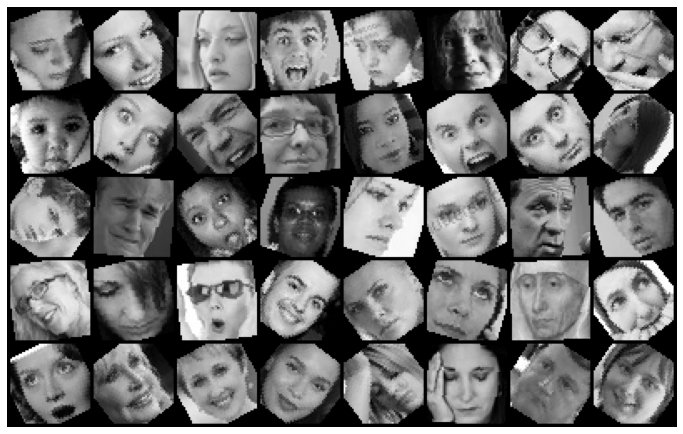

In [50]:
visualize_dataloader(train_dl)

## Defining model

First, try same approach as in face recognition project.. same architecture

In [95]:
class ConvModel(nn.Module):
  def __init__(self, classes):
    super(ConvModel, self).__init__()
    self.conv_layers = nn.Sequential(
        # input size: 3x48x48 (3:rgb, 48:width, 48:height)
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1)),
        # output: 32x46x46 (because kerne_size=3 and no padding)
        nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), ceil_mode=True),
        # output: 32x23x23 (note for myself: ceil_mode doesn't do padding on both sides!)
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
        # output: 64x21x21
        nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
        # output: 64x10x10
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1)),
        # output: 64x8x8
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
        # output: 64x4x4
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2), stride=(1,1)),
        # output: 128x3x3
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1)),
        # output: 256x1x1
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=256, out_channels=classes, kernel_size=(1,1), stride=(1,1))
        # output: 2x1x1
      )
      
  def forward(self, x):
    # as seen in tutorial:
    # no flattening here, expected input is of dimension batch_size x n_channels x im_height x im_width
    output = self.conv_layers(x)
    return output

In [21]:
class CNN(nn.Module):
  def __init__(self, num_classes=7):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.PReLU(),
        nn.ZeroPad2d(2),
        nn.MaxPool2d(kernel_size=5, stride=2)
        )

    self.layer2 = nn.Sequential(
      nn.ZeroPad2d(padding=1),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(padding=1)
      )

    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3),
      nn.PReLU(),
      nn.AvgPool2d(kernel_size=3, stride=2)
      )

    self.layer4 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU()
      )

    self.layer5 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(1),
      nn.AvgPool2d(kernel_size=3, stride=2)
      )

    self.fc1 = nn.Linear(3200, 1024)
    self.prelu = nn.PReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 7)
    self.log_softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.prelu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.prelu(x)
    x = self.dropout(x)

    y = self.fc3(x)
    y = self.log_softmax(y)
    return y

In [51]:
def plot_metrics(n_epochs, losses_train, losses_val, accs_train, accs_val):
    """ This method plots the (avg) losses and the accuracy per epoch of the training set and the 
    validation set in the same subplot for direct comparison"""
    
    plt.figure(1, figsize=(15,4.5))
   
    plt.subplot(1,2,1)
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(losses_val), label='Validation')
    plt.title("Average loss per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.subplot(1,2,2)
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_train), label='Training')
    plt.scatter(np.arange(1, n_epochs+1), np.array(accs_val), label='Validation')
    plt.title("Average accuracy per epoch", y=-0.24, fontweight='bold', fontsize=13)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.xticks(np.arange(1, n_epochs+1))
    
    plt.show()


def train(model, train_dataloader, optimizer, loss_fn):
  """Training the given model with train dataloader for one epoch"""
  model.train()
  losses = []
  correct_classifications = 0
  
  for iteration, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    optimizer.zero_grad()
    #output = output.reshape(-1,2)  # reshape output for feeding it to cross entropy loss
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
      
    # compute accuracy and loss for iteration
    losses.append(loss.item())
    correct_classifications += torch.sum(output.argmax(1) == labels).item()
  
  # compute accuracy of overall training
  accuracy = 100 * correct_classifications / len(train_dataloader.dataset)
  
  return np.mean(np.array(losses)), accuracy


def test(model, test_dataloader, loss_fn):
  """Testing the model with given test dataloader"""
  model.eval()
  
  test_loss, correct_classifications = 0, 0
  with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      #output = output.reshape(-1,2)  # reshape output for feeding it to cross entropy loss
      loss = loss_fn(output, labels)
      
      test_loss += loss.item()
      correct_classifications += torch.sum(output.argmax(1) == labels).item()
  
  avg_loss = test_loss / len(test_dataloader)
  accuracy = 100 * correct_classifications / len(test_dataloader.dataset)
  
  return avg_loss, accuracy


def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs, plot=False):
  """Trains the model with given parameters. If plot is True then plots will be done in this method"""
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []
  
  for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
    val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    
  if plot == True:
    # if plot is true then the accuracies and losses of train and val will be plotted
    # if plot is False one can invoke the plot_metrics function separately (more practical sometimes)
    plot_metrics(np.array(n_epochs),
                  np.array(train_losses), np.array(val_losses),
                  np.array(train_accuracies, np.array(val_accuracies)))

  return train_losses, train_accuracies, val_losses, val_accuracies

In [29]:
model = CNN()
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [30]:
train_losses, train_accuracies, val_losses, val_accuracies = fit(model, train_dl, val_dl, optimizer, loss_fn, n_epochs)

Epoch 1/10: train_loss: 27947223081.4932, train_accuracy: 16.7970, val_loss: 9085710.5222, val_accuracy: 17.5200
Epoch 2/10: train_loss: 2020599.0540, train_accuracy: 17.2033, val_loss: 1583066.4722, val_accuracy: 16.9279
Epoch 3/10: train_loss: 440112.8854, train_accuracy: 16.6847, val_loss: 435081.3028, val_accuracy: 16.9279
Epoch 4/10: train_loss: 471041.6958, train_accuracy: 16.8086, val_loss: 211969.9017, val_accuracy: 17.4852
Epoch 5/10: train_loss: 59250.3875, train_accuracy: 16.0887, val_loss: 17710.2566, val_accuracy: 17.5200
Epoch 6/10: train_loss: 37956.3402, train_accuracy: 16.5454, val_loss: 27678.1501, val_accuracy: 16.9279
Epoch 7/10: train_loss: 1017102871779420032.0000, train_accuracy: 16.0964, val_loss: 3277804636122330112.0000, val_accuracy: 16.9279
Epoch 8/10: train_loss: 39590955048846448.0000, train_accuracy: 19.0069, val_loss: 364798292589135.6250, val_accuracy: 23.7200
Epoch 9/10: train_loss: 330417343425465.0000, train_accuracy: 18.9875, val_loss: 1723056150486

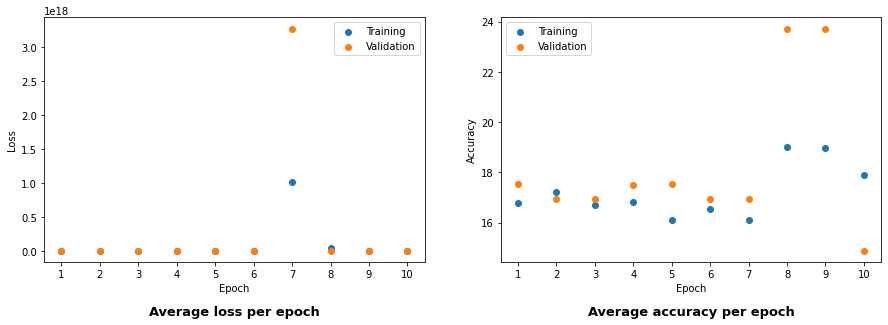

In [31]:
plot_metrics(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

In [32]:
# Evaluate:
loss, acc = test(model, val_dl, loss_fn)
print('Loss on validation set: ' + str(loss) + '\tAccuracy on validation set: ' + str(acc))

Loss on validation set: 237930413870284.8	Accuracy on validation set: 14.907697666318356


Some information for me:

Seeing the loss over time can yield interesting findings of our models. If the loss value is not decreasing, but it just oscillates, the model might not be learning at all. However, if it’s decreasing in the training set but not in the validation set (or it decreases but there’s a notable difference), then the model might be overfitting. In other words, it might be overlearning from the training examples, becoming useless in new examples. If that’s the case, it would be interesting to use regularization, use simpler models, or, in Deep Learning, just reduce the learning rate.

Having a low accuracy but a high loss would mean that the model makes big errors in most of the data. But, if both loss and accuracy are low, it means the model makes small errors in most of the data. However, if they’re both high, it makes big errors in some of the data. Finally, if the accuracy is high and the loss is low, then the model makes small errors on just some of the data, which would be the ideal case.


My words:
In my first iteration: Loss is decreasing, accuracy is stable. Meaning -> Errors are getting smaller but accuracy (right predictions) are not increasing. That could be the consequences of maybe not well distributed data sets (as mentioned already once above) or can maybe be fixed with regularization methods? Let's try adding dropout layers. Also, loss decreases and then explosingly increases.. could mean, that at this point the learning rate is too high... make it smaller

also: Remove the nn.Softmax at the end of the model, since nn.CrossEntropyLoss will internally apply F.log_softmax and nn.NLLLoss.

In [52]:
class CNN_2(nn.Module):
  def __init__(self, num_classes=7, dropout_parameter=0.2):
    super(CNN_2, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.PReLU(),
        nn.ZeroPad2d(2),
        nn.MaxPool2d(kernel_size=5, stride=2),
        nn.Dropout2d(dropout_parameter),
        )

    self.layer2 = nn.Sequential(
      nn.ZeroPad2d(padding=1),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(padding=1),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3),
      nn.PReLU(),
      nn.AvgPool2d(kernel_size=3, stride=2),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer4 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.Dropout2d(dropout_parameter),
      )

    self.layer5 = nn.Sequential(
      nn.ZeroPad2d(1),
      nn.Conv2d(128, 128, kernel_size=3),
      nn.PReLU(),
      nn.ZeroPad2d(1),
      nn.AvgPool2d(kernel_size=3, stride=2),
      nn.Dropout2d(dropout_parameter),
      )

    self.fc1 = nn.Linear(3200, 1024)
    self.prelu = nn.PReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 7)
    self.log_softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.prelu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.prelu(x)
    x = self.dropout(x)

    y = self.fc3(x)
    #y = self.log_softmax(y)
    return y

In [58]:
model_2 = CNN_2()
model_2 = model_2.to(device)
learning_rate_2 = 0.0003
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=learning_rate_2)
n_epochs_2 = 10
loss_fn_2 = nn.CrossEntropyLoss()

In [59]:
train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = fit(model_2, train_dl, val_dl, optimizer_2, loss_fn_2, n_epochs_2)

Epoch 1/10: train_loss: 1.8073, train_accuracy: 25.0484, val_loss: 1.7867, val_accuracy: 24.8346
Epoch 2/10: train_loss: 1.7608, train_accuracy: 27.3086, val_loss: 1.7125, val_accuracy: 31.3480
Epoch 3/10: train_loss: 1.6530, train_accuracy: 34.5421, val_loss: 1.5635, val_accuracy: 38.7321
Epoch 4/10: train_loss: 1.5570, train_accuracy: 39.2368, val_loss: 1.4696, val_accuracy: 44.1310
Epoch 5/10: train_loss: 1.4823, train_accuracy: 42.6117, val_loss: 1.4381, val_accuracy: 43.7827
Epoch 6/10: train_loss: 1.4334, train_accuracy: 44.5274, val_loss: 1.3774, val_accuracy: 46.8478
Epoch 7/10: train_loss: 1.3915, train_accuracy: 46.5284, val_loss: 1.3278, val_accuracy: 47.8231
Epoch 8/10: train_loss: 1.3570, train_accuracy: 47.8946, val_loss: 1.3094, val_accuracy: 50.6095
Epoch 9/10: train_loss: 1.3289, train_accuracy: 49.2801, val_loss: 1.2752, val_accuracy: 51.4107
Epoch 10/10: train_loss: 1.3087, train_accuracy: 49.9226, val_loss: 1.2481, val_accuracy: 52.0028


Much better results than before and we see a learning curve, nice. 
Unfortunately the accuracy is still not enough.

In [1]:
plot_metrics(n_epochs_2, train_losses_2, val_losses_2, train_accuracies_2, val_accuracies_2)

NameError: ignored

## Training, evaluation and testing

## Conclusion